In [2]:
from ast import literal_eval
import csv


In [3]:
from collections import namedtuple
NoduleInfoTuple = namedtuple(
    "NoduleInfoTuple",
    ["isNodule_bool", "nod_id", "center_lps", "file_path"]
)


def getNoduleInfoList():
    coord_file = "/home/kaplinsp/ct_lung_class/ct_lung_class/annots_michelle.csv"
    nodule_infos = []
    
    with open(coord_file) as f:
        reader = csv.reader(f, delimiter=",", quoting=csv.QUOTE_MINIMAL)
        next(reader)
        for row in reader:
            
            subject_id = row[2]
            try:
                coords = literal_eval(row[7])
            except SyntaxError:
                print(f"No coordinates for {subject_id}")
                continue
            file_path = f"/data/kaplinsp/prasad_d/{subject_id}.nrrd"
            nodule_infos.append(NoduleInfoTuple(1, subject_id, coords, file_path))
    
    return nodule_infos   

noduleInfo_list = getNoduleInfoList()


No coordinates for RIA_17-353D_Prasad_000_32
No coordinates for RIA_17-353D_Prasad_000_98
No coordinates for RIA_17-353D_Prasad_000_205
No coordinates for RIA_17-353D_Prasad_000_226
No coordinates for RIA_17-353D_Prasad_000_369
No coordinates for RIA_17-353D_Prasad_000_370
No coordinates for RIA_17-353D_Prasad_000_382


In [3]:
import os
import SimpleITK as sitk
import numpy as np
from util.util import XyzTuple, IrcTuple, irc2xyz, xyz2irc
import matplotlib.pyplot as plt

class CTImage:
    def __init__(self, nod_id):
        # nrrd_path = os.path.join(DATA_DIR, f"nod{nod_id}.nrrd")
        nrrd_path = os.path.join("/data/kaplinsp/prasad_d/", f"{nod_id}.nrrd")

        reader = sitk.ImageFileReader()
        reader.SetImageIO("NrrdImageIO")
        reader.SetFileName(nrrd_path)
        ct_nrrd = reader.Execute()
        self.image = ct_nrrd
        ct_a = np.array(sitk.GetArrayFromImage(ct_nrrd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down

        ct_a.clip(-1350, 150, ct_a)

        self.nod_id = nod_id
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_nrrd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_nrrd.GetSpacing())
        self.direction_a = np.array(ct_nrrd.GetDirection()).reshape(3, 3)

    def getRawNodule(self, center_xyz: XyzTuple, width_irc: IrcTuple):
        center_irc = irc2xyz(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )
        # center_irc = center_xyz

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis] / 2))
            end_ndx = int(start_ndx + width_irc[axis])

            # print(self.nod_id)
            # assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr(
            #     [self.nod_id, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis]
            # )
            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        return self.hu_a[tuple(slice_list)], center_irc
    

# def lps_to_voxel(lps_coords, image):
#     # Convert LPS coordinates to voxel coordinates
#     voxel_coords = image.TransformPhysicalPointToIndex(lps_coords)
#     return np.array(voxel_coords, dtype=int)

def extract_bounding_box(image_array, voxel_coords, box_size=200):
    z, y, x = voxel_coords  # Adjust for reversed order
    half_size = box_size // 2
    
    # Calculate the bounding box limits
    x_min = max(0, x - half_size)
    x_max = min(image_array.shape[0], x + half_size)
    y_min = max(0, y - half_size)
    y_max = min(image_array.shape[1], y + half_size)
    z_min = max(0, z - half_size)
    z_max = min(image_array.shape[2], z + half_size)
    
    # Ensure indices are integers
    x_min, x_max, y_min, y_max, z_min, z_max = map(int, [x_min, x_max, y_min, y_max, z_min, z_max])
    
    # Print bounding box limits for debugging
    print(f"Bounding box limits: z: ({z_min}, {z_max}), y: ({y_min}, {y_max}), x: ({x_min}, {x_max})")
    
    # Extract the bounding box
    bounding_box = image_array[x_min:x_max, y_min:y_max, z_min:z_max]
    
    return bounding_box

failures = []
"""THIS WORKS FOR DICOM"""
for nodule in noduleInfo_list:
    if nodule.nod_id == "RIA_17-353D_Prasad_000_233":
        # nrrd_path = os.path.join("/data/kaplinsp/prasad_d/", f"{nodule.nod_id}.nrrd")

        reader = sitk.ImageSeriesReader()
        dicom_files = reader.GetGDCMSeriesFileNames("/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_233")
        reader.SetFileNames(dicom_files)
        image = reader.Execute()
        # reader.SetImageIO("NrrdImageIO")
        # reader.SetFileName(nrrd_path)
        # image = reader.Execute()
        # index = np.array(nodule.center_xyz)[::-1]
        center_transformed = np.array(nodule.center_xyz)
        center_transformed[0] *= - 1
        center_transformed[1] *= -1
        print(center_transformed)
        index = image.TransformPhysicalPointToIndex(center_transformed)
        
        size_x = 200  # Size in the x-direction
        size_y = 200  # Size in the y-direction
        size_z = 30  # Size in the z-direction

        # Define the bounding box limits
        start_x = int(max(0, index[0] - size_x // 2))
        end_x = int(min(image.GetWidth(), index[0] + size_x // 2))

        # index[1] = image.GetHeight() - index[1]
        start_y = int(max(0, index[1] - size_y // 2))
        end_y = int(min(image.GetHeight(), index[1] + size_y // 2))

        start_z = int(max(0, index[2] - size_z // 2))
        end_z = int(min(image.GetDepth(), index[2] + size_z // 2))

        image_array = sitk.GetArrayFromImage(image)
        sliced = image_array[slice(start_z, end_z), slice(start_y, end_y), slice(start_x, end_x)]        
        plt.imshow(sliced[15, :, :], cmap="gray")
        plt.title('X-axis slice of the bounding box region')
        plt.colorbar()
        plt.show()


    


AttributeError: 'NoduleInfoTuple' object has no attribute 'center_xyz'

lungmask 2024-07-01 00:05:05 Postprocessing


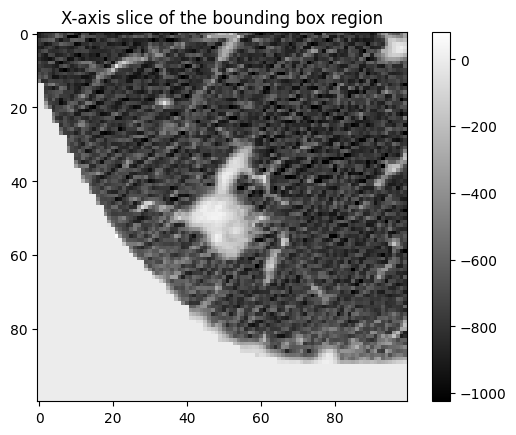

NameError: name 'NoduleInfoTuple' is not defined

In [2]:
from functools import lru_cache
import functools
from typing import List, Optional, Tuple
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# from datasets import get_coord_csv
from lungmask import LMInferer

class NoduleImage:
    def __init__(self, nod_id: str, image_file_path: str, center_lps: np.array):
        self.nod_id = nod_id
        self.image_file_path = image_file_path
        self.center_lps = center_lps
        
    def _image(self):
        raise NotImplementedError("Subclasses must override")
        
    @property
    def image(self):
        return self._image()
    
    @functools.lru_cache(maxsize=2)
    def image_array(self, segmented: Optional[bool] = False) -> np.array:
        image_arr = sitk.GetArrayFromImage(self.image)
        if not segmented:
            return image_arr
        
        inferrer = LMInferer(tqdm_disable=True)
        mask = inferrer.apply(image_arr)
        return image_arr * mask.astype(bool)
        
    
    
    def nodule_slice(self, box_dim: Tuple[int, int, int] = (60,60,60), segmented: Optional[bool] = False) -> np.array:
        index = self.image.TransformPhysicalPointToIndex(self.center_lps)
        size_x, size_y, size_z = box_dim
        
        start_x = int(max(0, index[0] - size_x // 2))
        end_x = int(min(self.image.GetWidth(), index[0] + size_x // 2))

        start_y = int(max(0, index[1] - size_y // 2))
        end_y = int(min(self.image.GetHeight(), index[1] + size_y // 2))

        start_z = int(max(0, index[2] - size_z // 2))
        end_z = int(min(self.image.GetDepth(), index[2] + size_z // 2))

        image_array = self.image_array(segmented=segmented)
        
        return image_array[slice(start_z, end_z), slice(start_y, end_y), slice(start_x, end_x)] 
    

class NRRDNodule(NoduleImage):
    """Class for loading nodules from NRRD"""
    
    @lru_cache(maxsize=1)
    def _image(self) -> sitk.Image:
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NrrdImageIO")
        reader.SetFileName(self.image_file_path)
        return reader.Execute()
    


class DICOMNodule(NoduleImage):
    """Class for loading an image of a nodule from DICOM"""
    
    @lru_cache(maxsize=1)
    def _image(self) -> sitk.Image:
        reader = sitk.ImageSeriesReader()
        dicom_files = reader.GetGDCMSeriesFileNames(self.image_file_path)
        reader.SetFileNames(dicom_files)
        image = reader.Execute()
        return image
    
    
def ras_to_lps(tup):
    tup[0] *= -1
    tup[1] *= -1
    return tup

def test_dicom_nodule():
    nodule = DICOMNodule(nod_id="RIA_17-353D_Prasad_000_35", 
                         image_file_path="/home/kaplinsp/ct_lung_class/581691/scans/4-1_25/resources/DICOM/files",
                         center_lps=ras_to_lps([51.4106, -46.4581, -142.25])
    )
    # nodule = NRRDNodule(
    #     nod_id="3",
    #     image_file_path = f"/data/etay/lung_hist_dat/original_dat_nrrds/nod3.nrrd",
    #     center_lps = get_coord_csv("R74","P80","I172")
    # )
    
    slice = nodule.nodule_slice(box_dim=(100,100,30), segmented=True)
    plt.imshow(slice[16, :, :], cmap="gray")
    plt.title('X-axis slice of the bounding box region')
    plt.colorbar()
    plt.show()
test_dicom_nodule()


def load_annotation_michelle() -> List[NoduleInfoTuple]:
    coord_file = "/home/kaplinsp/ct_lung_class/ct_lung_class/annots_michelle.csv"
    nodule_infos = []
    
    with open(coord_file) as f:
        reader = csv.reader(f, delimiter=",", quoting=csv.QUOTE_MINIMAL)
        next(reader)
        for row in reader:
            
            subject_id = row[2]
            try:
                coords = literal_eval(row[7])
                coords = ras_to_lps(coords)
            except SyntaxError:
                log.warning(f"No coordinates for {subject_id}")
                continue
            nodule_infos.append(NoduleInfoTuple(1, subject_id, coords, "file_path"))
    
    return nodule_infos            

In [21]:
from lungmask import LMInferer

nodule = DICOMNodule(nod_id="RIA_17-353D_Prasad_000_35", 
                         image_file_path="/home/kaplinsp/ct_lung_class/581691/scans/4-1_25/resources/DICOM/files",
                         center_lps=ras_to_lps([51.4106, -46.4581, -142.25])
)
inferer = LMInferer()
seg = inferer.apply(sitk.GetArrayFromImage(nodule.image))

10it [00:00, 10.29it/s]                         

lungmask 2024-06-30 20:15:11 Postprocessing



100%|██████████| 33/33 [00:00<00:00, 156.23it/s]


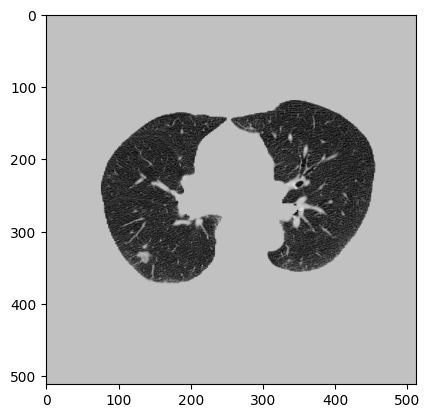

In [45]:
lung_only_array = sitk.GetArrayFromImage(nodule.image) * seg.astype(bool)
plt.imshow(lung_only_array[100], cmap="gray")